In [1]:
cd

/Users/keith_tetrad


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from bioservices import QuickGO
quickgo = QuickGO()

In [4]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('expand_frame_repr', False)


In [5]:
# import small data 
apms_data = pd.DataFrame(pd.read_csv('kw_dms/nevan_analysis/1-s2.0-S0092867423009157-mmc3(1).csv', delimiter=','))

#pull rnaseq data from angelas work here: https://elifesciences.org/articles/38795/figures#fig2s1
eLife_data = pd.DataFrame(pd.read_csv('kw_dms/nevan_analysis/elife-38795-fig2-data1-v2.csv', delimiter=','))

In [6]:
# Filter for rows where any of the specified columns is True
flag_apms_data = apms_data.loc[apms_data[['flag_SaintandMist_final', 'flag_Saint_final', 'flag_SaintandMistorNatureSaint_final']].any(axis=1)].reset_index(drop=True)

In [7]:
def go_term(go_id):
    # Define parameters
    taxon_id = "9606"  # Taxonomy ID for Homo sapiens
    go_id = go_id # GO term
    
    # Fetch annotations
    annotations = quickgo.Annotation(taxonId=taxon_id, goId=go_id)

    # Extract results
    results = annotations['results']

    # Extract gene products using 'symbol' key
    gene_products = [result['symbol'] for result in results if result.get('symbol')]

    # Extract gene products using 'symbol' key and add them to a list
    gene_products = [result['symbol'] for result in results if result.get('symbol')]

    # Convert the list to a set to remove duplicates, and then back to a list
    unique_gene_products = list(set(gene_products))
    
    return unique_gene_products

def go_term_mask(mask):

    # Create a boolean mask
    mask = flag_apms_data['PreyGene'].apply(lambda x: any(word in x for word in mask))
    
    return flag_apms_data[mask]

In [8]:
#ATP-dependent protein folding chaperone
GO_0140662 = go_term('GO:0140662')
ATP = go_term_mask(GO_0140662)

#protein folding in endoplasmic reticulum
GO_0034975 = go_term('GO:0034975')
ER = go_term_mask(GO_0034975)

#protein folding chaperone
GO_0044183 = go_term('GO:0044183')
all_chaps = go_term_mask(GO_0044183)

In [9]:
# Group by the 'ViralProtein' and aggregate unique values in 'PreyGene'
grouped = ATP.groupby('ViralProtein')['PreyGene'].unique()

# Group by both 'variant' and 'ViralProtein', then aggregate unique values in 'PreyGene'
grouped_byvariant = ER.groupby(['ViralProtein','Variant'])['PreyGene'].unique()

In [10]:
#extract a list of unique PreyGenes
unique_ER = ER['PreyGene'].unique()
unique_ATP = ATP['PreyGene'].unique()
unique_all_chaps = all_chaps['PreyGene'].unique()

# Combine and find unique values
combined_unique = np.concatenate((unique_ER, unique_ATP, unique_all_chaps))
unique_chaps = np.unique(combined_unique)

chunk_size = 10000  # Adjust based on your memory constraints
normal_tissue_data = pd.DataFrame()  # Initialize an empty DataFrame for the filtered data
rna_single_cell_data = pd.DataFrame()

for chunk in pd.read_csv('kw_dms/nevan_analysis/normal_tissue.tsv', sep='\t', chunksize=chunk_size):
    # Filter the chunk
    filtered_chunk = chunk[chunk['Gene name'].isin(unique_chaps)]
    # Append the filtered chunk to the DataFrame
    normal_tissue_data = pd.concat([normal_tissue_data, filtered_chunk])

for chunk in pd.read_csv('kw_dms/nevan_analysis/rna_single_cell_type.tsv', sep='\t', chunksize=chunk_size):
    # Filter the chunk
    filtered_chunk = chunk[chunk['Gene name'].isin(unique_chaps)]
    # Append the filtered chunk to the DataFrame
    rna_single_cell_data = pd.concat([rna_single_cell_data, filtered_chunk])
    

In [11]:
unique_tissue_cells = normal_tissue_data.groupby('Tissue')['Cell type'].unique()
unique_RNA_cells = rna_single_cell_data['Cell type'].unique()

In [12]:
tissue_cell_types = {
    'bronchus': ['respiratory epithelial cells', 'basal cells', 'Basal respiratory cells', 'Ciliated cells', 'ciliated cells (cell body)', 'ciliated cells (cilia axoneme)', 'ciliated cells (ciliary rootlets)', 'ciliated cells (tip of cilia)', 'goblet cells'],
    'kidney': ['cells in tubules', 'collecting ducts'],
    'lung': ['alveolar cells type I', 'alveolar cells type II', 'endothelial cells', 'alveolar cells'],
    'pancreas': ['exocrine glandular cells', 'pancreatic endocrine cells'],
    'skin': ['Basal keratinocytes', 'Basal squamous epithelial cells']
}

# Filter for only tissue/cell type combinations
def filter_combinations(row):
    tissue = row['Tissue']
    cell_type = row['Cell type']
    return cell_type in tissue_cell_types.get(tissue, [])

# Filter the DataFrame
tissue_SARS_filtered = normal_tissue_data[normal_tissue_data.apply(filter_combinations, axis=1)].reset_index(drop=True)

# Aggregate all unique cell types from the dictionary
all_cell_types = set()
for cell_types in tissue_cell_types.values():
    all_cell_types.update(cell_types)

# Cleaning up cell type names (some of this may not be biologically correct)
replacements = {
    'Alveolar cells type 1': 'alveolar cells type I',
    'Alveolar cells type 2': 'alveolar cells type II',
    'Collecting duct cells': 'collecting ducts',
    'Endothelial cells': 'endothelial cells',
    'Exocrine glandular cells': 'exocrine glandular cells',
    'Pancreatic endocrine cells': 'pancreatic endocrine cells'
}
rna_single_cell_data['Cell type'] = rna_single_cell_data['Cell type'].replace(replacements)

# Filter rna_single_cell_data based on the cell types
rna_single_cell_SARS_filtered = rna_single_cell_data[rna_single_cell_data['Cell type'].isin(all_cell_types)].reset_index(drop=True)


In [13]:
# Group by the 'ViralProtein' and aggregate unique values in 'PreyGene'
grouped = ATP.groupby('ViralProtein')['PreyGene'].unique()

# Group by both 'variant' and 'ViralProtein', then aggregate unique values in 'PreyGene'
grouped_byvariant = ER.groupby(['ViralProtein','Variant'])['PreyGene'].unique()

In [14]:
unique_chaps_list = unique_chaps.tolist()

filtered_elife_data = eLife_data[eLife_data['GeneSymbol'].isin(unique_chaps_list)].copy()

# Replace '#NUM!' with NaN
filtered_elife_data.replace('#NUM!', np.nan, inplace=True)

# Iterate through each column (skipping the first one)
for column in filtered_elife_data.columns[1:]:
    # Convert to float, coercing errors to NaN
    filtered_elife_data[column] = pd.to_numeric(filtered_elife_data[column], errors='coerce')

    # Replace NaN with the max value of the column
    max_value = filtered_elife_data[column].max()
    filtered_elife_data[column].fillna(max_value, inplace=True)

CALR


eLife RNAseq data:
XBPS1s Log2 fold change: 1.211851
-log10 pvalue: 121.028801
ATF6/XBP1s Log2 fold change: 2.41991
-log10 pvalue: 252.106825


protein immunohistochemistry data:
  Tissue                  Cell type Reliability        Level
  kidney           cells in tubules    Enhanced         High
    lung      alveolar cells type I    Enhanced Not detected
    lung     alveolar cells type II    Enhanced       Medium
    lung          endothelial cells    Enhanced Not detected
pancreas   exocrine glandular cells    Enhanced         High
pancreas pancreatic endocrine cells    Enhanced       Medium


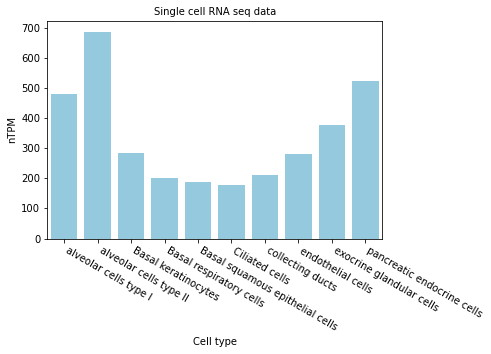

In [29]:
# Define the specific gene you are interested in
specific_gene = 'CALR'  # Replace with the actual gene identifier

# Filter the DataFrame for the specific gene
specific_gene_tissue = tissue_SARS_filtered[tissue_SARS_filtered['Gene name'] == specific_gene]
specific_gene_rna = rna_single_cell_SARS_filtered[rna_single_cell_SARS_filtered['Gene name'] == specific_gene]
# Print the results
print(specific_gene)
print('\n')
print('eLife RNAseq data:')
print('XBPS1s Log2 fold change:', filtered_elife_data.loc[filtered_elife_data['GeneSymbol'] == specific_gene, 'log2FoldChange_XBP1s37/basal37'].to_string(index=False))
print('-log10 pvalue:', filtered_elife_data.loc[filtered_elife_data['GeneSymbol'] == specific_gene, '-log10_pvalue_XBP1s37/basal37'].to_string(index=False))
print('ATF6/XBP1s Log2 fold change:', filtered_elife_data.loc[filtered_elife_data['GeneSymbol'] == specific_gene, 'log2FoldChange_ATF6fXBP1s37/basal37'].to_string(index=False))
print('-log10 pvalue:', filtered_elife_data.loc[filtered_elife_data['GeneSymbol'] == specific_gene, '-log10_pvalue_ATF6fXBP1s37/basal37'].to_string(index=False))

print('\n')
print('protein immunohistochemistry data:')
print(tissue_SARS_filtered.loc[tissue_SARS_filtered['Gene name'] == specific_gene, ['Tissue','Cell type', 'Reliability', 'Level']].to_string(index=False))

# Create the barplot with a uniform color
sns.barplot(data=specific_gene_rna, x='Cell type', y='nTPM', color='skyblue')
plt.xticks(rotation=-30, ha='left')
plt.title('Single cell RNA seq data', fontsize=10)

plt.show()

In [26]:
# Create the interactive plot with Plotly
fig = px.scatter(filtered_elife_data, 
                 x='log2FoldChange_XBP1s37/basal37', 
                 y='-log10_pvalue_XBP1s37/basal37', 
                 color='GeneSymbol',
                 hover_data=['GeneSymbol'])

# Add and center the title for the first plot
fig.update_layout(title={'text': 'XBP1s 37˚C vs. Basal 37˚C', 'x':0.5, 'y':0.92, 'xanchor': 'center'})

# Show the plot
fig.show()

# Create the interactive plot with Plotly
fig = px.scatter(filtered_elife_data, 
                 x='log2FoldChange_ATF6fXBP1s37/basal37', 
                 y='-log10_pvalue_ATF6fXBP1s37/basal37', 
                 color='GeneSymbol',
                 hover_data=['GeneSymbol'])

# Add and center the title for the first plot
fig.update_layout(title={'text': 'ATF6/XBP1s 37˚C vs. Basal 37˚C', 'x':0.5, 'y':0.92, 'xanchor': 'center'})

# Show the plot
fig.show()